In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer
from sklearn.model_selection import train_test_split

# Paso 1: Cargar la base de datos
data = pd.read_csv('resultado_limpio.csv')
sequences = data['Seqence'].tolist()
labels = data['Activity'].tolist()

# Transformar las etiquetas en formato binario
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform([label.split(',') for label in labels])

# Paso 2: Preparar el dataset personalizado
class PeptideDataset(Dataset):
    def __init__(self, sequences, labels, max_length=100):
        self.sequences = sequences
        self.labels = labels
        self.max_length = max_length
        self.encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
        self.encoder.fit(np.array([list("ACDEFGHIKLMNPQRSTVWY")]).T)  # One-hot encoding de los aminoácidos

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = list(self.sequences[idx])
        if len(sequence) < self.max_length:
            sequence += ['X'] * (self.max_length - len(sequence))
        else:
            sequence = sequence[:self.max_length]

        sequence = np.array(sequence).reshape(-1, 1)
        sequence_encoded = self.encoder.transform(sequence)
        sequence_encoded = torch.tensor(sequence_encoded, dtype=torch.float32)

        # Convertir la etiqueta a tensor (vector binario)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)  # Cambiar a float para multilabel
        return sequence_encoded, label

# Paso 3: División de datos en conjunto de entrenamiento y validación
train_sequences, val_sequences, train_labels, val_labels = train_test_split(sequences, labels, test_size=0.2, random_state=42)
train_dataset = PeptideDataset(train_sequences, train_labels)
val_dataset = PeptideDataset(val_sequences, val_labels)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32)

# Paso 4: Definir el modelo CNN
class ImprovedCNN(nn.Module):
    def __init__(self, num_classes, max_length=100):
        super(ImprovedCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=20, out_channels=64, kernel_size=5, padding=2)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=7, padding=3)
        self.conv3 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.5)

        # Calcular el tamaño de la salida de las capas convolucionales
        dummy_input = torch.zeros(1, 20, max_length)
        dummy_output = self._forward_features(dummy_input)
        flattened_size = dummy_output.shape[1] * dummy_output.shape[2]

        # Capas completamente conectadas
        self.fc1 = nn.Linear(flattened_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def _forward_features(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = torch.relu(self.conv3(x))
        x = self.pool(x)
        return x

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Cambiar la dimensión para Conv1d
        x = self._forward_features(x)
        x = x.view(x.size(0), -1)  # Aplanar
        x = self.dropout(x)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Paso 5: Configurar el modelo, la función de pérdida y el optimizador
num_classes = labels.shape[1]  # Número de clases únicas en el conjunto de datos
model = ImprovedCNN(num_classes)
criterion = nn.BCEWithLogitsLoss()  # Cambiar la función de pérdida
optimizer = optim.Adam(model.parameters(), lr=0.00001, weight_decay=0.001)

# Paso 6: Definir funciones de entrenamiento y evaluación
def train(model, dataloader, criterion, optimizer):
    model.train()
    total_loss = 0
    for sequences, labels in dataloader:
        optimizer.zero_grad()
        outputs = model(sequences)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for sequences, labels in dataloader:
            outputs = model(sequences)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # Aplicar una umbralización para convertir logits en predicciones
            predicted = (torch.sigmoid(outputs) > 0.5).float()  # Ajusta el umbral según sea necesario
            correct += (predicted == labels).sum().item()
    accuracy = correct / (len(dataloader.dataset) * labels.shape[1])  # Normalizar por número de clases
    return total_loss / len(dataloader), accuracy

# Paso 7: Entrenamiento del modelo
num_epochs = 50
for epoch in range(num_epochs):
    train_loss = train(model, train_dataloader, criterion, optimizer)
    val_loss, val_accuracy = evaluate(model, val_dataloader, criterion)
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}")

Epoch 1/50, Training Loss: 0.7062
Validation Loss: 0.7017, Accuracy: 0.3121
Epoch 2/50, Training Loss: 0.6979
Validation Loss: 0.6908, Accuracy: 0.5183
Epoch 3/50, Training Loss: 0.6804
Validation Loss: 0.6631, Accuracy: 0.7996
Epoch 4/50, Training Loss: 0.6289
Validation Loss: 0.5839, Accuracy: 0.8815
Epoch 5/50, Training Loss: 0.5056
Validation Loss: 0.4329, Accuracy: 0.8898
Epoch 6/50, Training Loss: 0.3497
Validation Loss: 0.3002, Accuracy: 0.9300
Epoch 7/50, Training Loss: 0.2508
Validation Loss: 0.2379, Accuracy: 0.9300
Epoch 8/50, Training Loss: 0.2106
Validation Loss: 0.2150, Accuracy: 0.9300
Epoch 9/50, Training Loss: 0.1931
Validation Loss: 0.2051, Accuracy: 0.9300
Epoch 10/50, Training Loss: 0.1850
Validation Loss: 0.1995, Accuracy: 0.9300
Epoch 11/50, Training Loss: 0.1820
Validation Loss: 0.1956, Accuracy: 0.9300
Epoch 12/50, Training Loss: 0.1798
Validation Loss: 0.1931, Accuracy: 0.9300
Epoch 13/50, Training Loss: 0.1772
Validation Loss: 0.1915, Accuracy: 0.9300
Epoch 14

Epoch 1/50, Training Loss: 0.1571
Validation Loss: 0.1738, Accuracy: 0.9300
Epoch 2/50, Training Loss: 0.1571
Validation Loss: 0.1734, Accuracy: 0.9300
Epoch 3/50, Training Loss: 0.1559
Validation Loss: 0.1733, Accuracy: 0.9300
Epoch 4/50, Training Loss: 0.1569
Validation Loss: 0.1730, Accuracy: 0.9302
Epoch 5/50, Training Loss: 0.1556
Validation Loss: 0.1730, Accuracy: 0.9300
Epoch 6/50, Training Loss: 0.1556
Validation Loss: 0.1726, Accuracy: 0.9304
Epoch 7/50, Training Loss: 0.1552
Validation Loss: 0.1724, Accuracy: 0.9315
Epoch 8/50, Training Loss: 0.1556
Validation Loss: 0.1722, Accuracy: 0.9323
Epoch 9/50, Training Loss: 0.1535
Validation Loss: 0.1720, Accuracy: 0.9337
Epoch 10/50, Training Loss: 0.1551
Validation Loss: 0.1718, Accuracy: 0.9335
Epoch 11/50, Training Loss: 0.1536
Validation Loss: 0.1716, Accuracy: 0.9331
Epoch 12/50, Training Loss: 0.1545
Validation Loss: 0.1713, Accuracy: 0.9327
Epoch 13/50, Training Loss: 0.1542
Validation Loss: 0.1712, Accuracy: 0.9333
Epoch 14

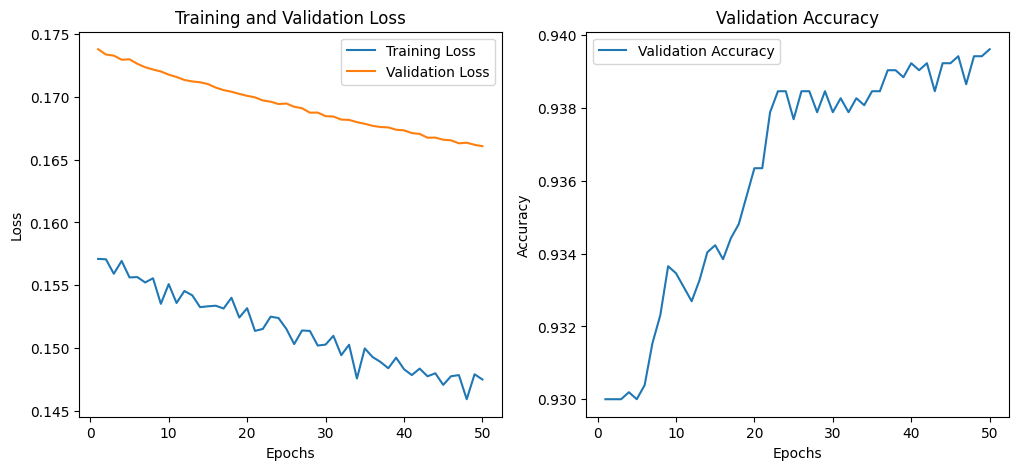

In [16]:
import matplotlib.pyplot as plt

# Inicializa listas para almacenar pérdidas y precisiones
train_losses = []
val_losses = []
val_accuracies = []

# Paso 7: Entrenamiento del modelo con almacenamiento de métricas
num_epochs = 50
for epoch in range(num_epochs):
    train_loss = train(model, train_dataloader, criterion, optimizer)
    val_loss, val_accuracy = evaluate(model, val_dataloader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}")

# Graficar la pérdida
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Graficar la precisión
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.show()

In [17]:

# Paso 9: Función para predecir propiedades antimicrobianas
def predict(model, sequence, encoder, mlb):
    model.eval()
    with torch.no_grad():
        sequence = list(sequence)
        # Padding o recorte de la secuencia al máximo largo especificado
        if len(sequence) < 100:
            sequence += ['X'] * (100 - len(sequence))
        else:
            sequence = sequence[:100]

        sequence = np.array(sequence).reshape(-1, 1)
        sequence_encoded = encoder.transform(sequence)  # Utilizar el encoder pasado como argumento
        sequence_encoded = torch.tensor(sequence_encoded, dtype=torch.float32).unsqueeze(0)  # Agregar dimensión de batch

        outputs = model(sequence_encoded)
        predicted = torch.sigmoid(outputs) > 0.5  # Umbralizar para obtener predicciones binarias
    return predicted

# Ejemplo de uso para hacer predicciones
example_sequence = 'AELRCMCIKTTSGIHPKNIQSLEVIGKGTHCNQVEVIATLKDGRKICLDPDAPRIKKIVQKKLAGD'
predicted_properties = predict(model, example_sequence, train_dataset.encoder, mlb)  # Pasar el encoder y el mlb

# Imprimir las predicciones
print("Predicted properties (binary):", predicted_properties.numpy())
print("Predicted properties (classes):", mlb.inverse_transform(predicted_properties.numpy()))

# Paso 10: Guardar el modelo
torch.save(model.state_dict(), 'modelo_cnn.pth')

# Para cargar el modelo posteriormente
loaded_model = ImprovedCNN(num_classes)
loaded_model.load_state_dict(torch.load('modelo_cnn.pth'))
loaded_model.eval()  # Establecer en modo evaluación

Predicted properties (binary): [[False False False False False False False False False  True False False
  False]]
Predicted properties (classes): [('Antibacterial',)]


<ipython-input-17-4abd42cf7260>:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load('modelo_cnn.pth'))


ImprovedCNN(
  (conv1): Conv1d(20, 64, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv2): Conv1d(64, 128, kernel_size=(7,), stride=(1,), padding=(3,))
  (conv3): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=3072, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=13, bias=True)
)

In [22]:
# Ejemplo de uso para hacer predicciones
example_sequence2 = 'GEWYNQTKDLQQKFYEIIMDIEQNNVQGKKGIQQL'
predicted_properties = predict(model, example_sequence2, train_dataset.encoder, mlb)  # Pasar el encoder y el mlb

# Imprimir las predicciones
print("Predicted properties (binary):", predicted_properties.numpy())
print("Predicted properties (classes):", mlb.inverse_transform(predicted_properties.numpy()))

Predicted properties (binary): [[False False False False False False False False False False False False
   True]]
Predicted properties (classes): [('Antiviral',)]


In [23]:
# Ejemplo de uso para hacer predicciones
example_sequence3 = 'QHGHGGQDQHGYGHGQQAVYGKGHEGHGVNNLGQDGHGQHGYAHGHSDQHGHGGQHGQHDGYKNRGY'
predicted_properties = predict(model, example_sequence3, train_dataset.encoder, mlb)  # Pasar el encoder y el mlb

# Imprimir las predicciones
print("Predicted properties (binary):", predicted_properties.numpy())
print("Predicted properties (classes):", mlb.inverse_transform(predicted_properties.numpy()))

Predicted properties (binary): [[False False False False False False False False False  True False False
  False]]
Predicted properties (classes): [('Antibacterial',)]


In [33]:
# Ejemplo de uso para hacer predicciones
example_sequence4 = 'LSGRARDDVRAWATR'
predicted_properties = predict(model, example_sequence4, train_dataset.encoder, mlb)  # Pasar el encoder y el mlb

# Imprimir las predicciones
print("Predicted properties (binary):", predicted_properties.numpy())
print("Predicted properties (classes):", mlb.inverse_transform(predicted_properties.numpy()))

Predicted properties (binary): [[False False False False False False False False False  True False False
  False]]
Predicted properties (classes): [('Antibacterial',)]


In [20]:
predicted_classes = mlb.inverse_transform(predicted_properties.numpy())
print("Predicted properties (classes):", predicted_classes)

Predicted properties (classes): [('Antiviral',)]


In [21]:
# Obtener las clases que se han usado para el entrenamiento
classes = mlb.classes_
print("Clases de propiedades antimicrobianas:", classes)

Clases de propiedades antimicrobianas: [' Antibiofilm' ' Anticancer' ' Antifungal' ' Antiinflammatory'
 ' Antiparasitic' ' Antitumor' ' Antitumour' ' Antiviral' ' Insecticidal'
 'Antibacterial' 'Antifungal' 'Antiparasitic' 'Antiviral']
